In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  4 14:33:21 2019

@author: Theo
"""


import numpy as np
from openpiv import windef
from openpiv.test import test_process 
from openpiv import preprocess
import pathlib
import os
import matplotlib.pyplot as plt


In [2]:

frame_a, frame_b = test_process.create_pair(image_size=256)
shift_u, shift_v, threshold = test_process.shift_u, test_process.shift_v, \
                              test_process.threshold

# this test are created only to test the displacement evaluation of the
# function the validation methods are not tested here ant therefore
# are disabled.

settings = windef.PIVSettings()
settings.windowsizes = (64,)
settings.overlap = (32,)
settings.num_iterations = 1
settings.correlation_method = 'circular'
settings.sig2noise_method = 'peak2peak'
settings.subpixel_method = 'gaussian'
settings.sig2noise_mask = 2



In [3]:

# circular cross correlation
def test_first_pass_circ():
    """ test of the first pass """
    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings
    )
    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold



In [4]:
test_first_pass_circ()


 [[ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]] [[ 32.  32.  32.  32.  32.  32.  32.]
 [ 64.  64.  64.  64.  64.  64.  64.]
 [ 96.  96.  96.  96.  96.  96.  96.]
 [128. 128. 128. 128. 128. 128. 128.]
 [160. 160. 160. 160. 160. 160. 160.]
 [192. 192. 192. 192. 192. 192. 192.]
 [224. 224. 224. 224. 224. 224. 224.]] [[-3.48978725 -3.48499347 -3.49450944 -3.503414   -3.48402216 -3.48231087
  -3.50317151]
 [-3.48664967 -3.4914311  -3.50149945 -3.49304027 -3.48893875 -3.48292755
  -3.50870595]
 [-3.4801534  -3.4878571  -3.49537239 -3.48706245 -3.48068811 -3.48282971
  -3.49722036]
 [-3.49119108 -3.48341923 -3.48779857 -3.48952858 -3.47403741 -3.48141831
  -3.49128564]
 [-3.48976035 -3.48927463 -3.48705397 -3.49097509 -3.45728252 -3.4617506
  -3.48191839]
 [-3.47709695 -3.491

In [5]:

def test_multi_pass_circ():
    """ test fot the multipass """
    settings.windowsizes = (64, 64, 16)
    settings.overlap = (32, 32, 8)
    settings.num_iterations = 2
    settings.interpolation_order = 3
    # ettings.show_all_plots = True

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )
    print("first pass\n")
    print("\n", x, y, u, v, s2n)
    assert np.allclose(u, shift_u, atol = threshold)
    assert np.allclose(v, shift_v, atol = threshold)

    u = np.ma.masked_array(u, mask=np.ma.nomask)
    v = np.ma.masked_array(v, mask=np.ma.nomask)

    for i in range(1,settings.num_iterations):
        x, y, u, v, s2n, _ = windef.multipass_img_deform(
            frame_a,
            frame_b,
            i,
            x,
            y,
            u,
            v,
            settings
        )

    print(f"Pass {i}\n")
    print(x)
    print(y)
    print(u) 
    print(v)
    print(s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold
    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


In [6]:
test_multi_pass_circ()

first pass


 [[ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]] [[ 32.  32.  32.  32.  32.  32.  32.]
 [ 64.  64.  64.  64.  64.  64.  64.]
 [ 96.  96.  96.  96.  96.  96.  96.]
 [128. 128. 128. 128. 128. 128. 128.]
 [160. 160. 160. 160. 160. 160. 160.]
 [192. 192. 192. 192. 192. 192. 192.]
 [224. 224. 224. 224. 224. 224. 224.]] [[-3.48978725 -3.48499347 -3.49450944 -3.503414   -3.48402216 -3.48231087
  -3.50317151]
 [-3.48664967 -3.4914311  -3.50149945 -3.49304027 -3.48893875 -3.48292755
  -3.50870595]
 [-3.4801534  -3.4878571  -3.49537239 -3.48706245 -3.48068811 -3.48282971
  -3.49722036]
 [-3.49119108 -3.48341923 -3.48779857 -3.48952858 -3.47403741 -3.48141831
  -3.49128564]
 [-3.48976035 -3.48927463 -3.48705397 -3.49097509 -3.45728252 -3.4617506
  -3.48191839]
 [-3.477

In [7]:


# linear cross correlation
def test_first_pass_lin():
    """ test of the first pass """
    settings.correlation_method = 'linear'

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )
    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold



In [8]:
test_first_pass_lin()


 [[ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]] [[ 32.  32.  32.  32.  32.  32.  32.]
 [ 64.  64.  64.  64.  64.  64.  64.]
 [ 96.  96.  96.  96.  96.  96.  96.]
 [128. 128. 128. 128. 128. 128. 128.]
 [160. 160. 160. 160. 160. 160. 160.]
 [192. 192. 192. 192. 192. 192. 192.]
 [224. 224. 224. 224. 224. 224. 224.]] [[-3.49131997 -3.48264603 -3.48853093 -3.48600852 -3.48290592 -3.47534818
  -3.49494222]
 [-3.48228215 -3.47802076 -3.48744255 -3.48562684 -3.48708739 -3.46687401
  -3.49046862]
 [-3.47612851 -3.47614725 -3.48687169 -3.4806925  -3.47994938 -3.47387586
  -3.4769835 ]
 [-3.48243706 -3.48472549 -3.48468284 -3.47929884 -3.46738361 -3.4716283
  -3.48247604]
 [-3.4744637  -3.47902932 -3.47358771 -3.48236146 -3.4590048  -3.46026719
  -3.47709542]
 [-3.46984691 -3.481

In [13]:

def test_invert_and_piv():
    """ Test windef.piv with invert option """

    settings = windef.PIVSettings()
    'Data related settings'
    # Folder with the images to process
    settings.filepath_images = pathlib.Path('../data/test1')
    settings.save_path = settings.filepath_images.parent
    # Root name of the output Folder for Result Files
    settings.save_folder_suffix = 'test'
    # Format and Image Sequence
    settings.frame_pattern_a = 'exp1_001_a.bmp'
    settings.frame_pattern_b = 'exp1_001_b.bmp'

    settings.num_iterations = 1
    settings.show_plot = False
    settings.scale_plot = 100
    settings.show_all_plots = True
    settings.invert = True

    windef.piv(settings)



In [14]:
test_invert_and_piv()

../data/test1
exp1_001_a.bmp
True
[PosixPath('../data/test1/exp1_001_a.bmp')]


TypeError: expected string or bytes-like object

In [ ]:

def test_multi_pass_lin():
    """ test fot the multipass """
    settings.windowsizes = (64, 32, 16)
    settings.overlap = (32, 16, 8)
    settings.num_iterations = 1
    settings.sig2noise_validate = True
    settings.correlation_method = 'linear'
    settings.normalized_correlation = True
    settings.sig2noise_method = 'peak2peak'
    settings.sig2noise_threshold = 1.0
    

    x, y, u, v, s2n = windef.first_pass(
        frame_a,
        frame_b,
        settings,
    )

    print("\n", x, y, u, v, s2n)
    assert np.mean(np.abs(u - shift_u)) < threshold
    assert np.mean(np.abs(v - shift_v)) < threshold


    mask_coords = []
    u = np.ma.masked_array(u, mask=np.ma.nomask)
    v = np.ma.masked_array(v, mask=np.ma.nomask)

    for i in range(1, settings.num_iterations):
        x, y, u, v, s2n, _ = windef.multipass_img_deform(
            frame_a,
            frame_b,
            i,
            x,
            y,
            u,
            v,
            settings,
        )
        print(f"Iteration {i}")
        print("\n", x, y, u, v, s2n)
        assert np.allclose(u, shift_u, atol=threshold)
        assert np.allclose(v, shift_v, atol=threshold)

    # the second condition is to check if the multipass is done.
    # It need's a little numerical inaccuracy.


In [ ]:
test_multi_pass_lin()


 [[ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]
 [ 32.  64.  96. 128. 160. 192. 224.]] [[ 32.  32.  32.  32.  32.  32.  32.]
 [ 64.  64.  64.  64.  64.  64.  64.]
 [ 96.  96.  96.  96.  96.  96.  96.]
 [128. 128. 128. 128. 128. 128. 128.]
 [160. 160. 160. 160. 160. 160. 160.]
 [192. 192. 192. 192. 192. 192. 192.]
 [224. 224. 224. 224. 224. 224. 224.]] [[-3.50485843 -3.48332997 -3.49078806 -3.49277908 -3.49590696 -3.48208088
  -3.48590116]
 [-3.50589097 -3.48007943 -3.48515445 -3.49083262 -3.49554331 -3.48984047
  -3.49194312]
 [-3.5035869  -3.48716385 -3.48070788 -3.4869222  -3.49388484 -3.4850113
  -3.50089203]
 [-3.50219318 -3.48619224 -3.48333041 -3.49183516 -3.4896985  -3.49017649
  -3.50756893]
 [-3.49790065 -3.48383438 -3.48414405 -3.48097465 -3.4866819  -3.49954319
  -3.51039237]
 [-3.4946533  -3.483

In [ ]:
from openpiv.pyprocess import extended_search_area_piv, get_field_shape, get_coordinates

u, v, s2n = extended_search_area_piv(
    frame_a,
    frame_b,
    window_size=settings.windowsizes[0],
    overlap=settings.overlap[0],
    search_area_size=settings.windowsizes[0],
    width=settings.sig2noise_mask,
    subpixel_method=settings.subpixel_method,
    sig2noise_method=settings.sig2noise_method,
    correlation_method=settings.correlation_method,
    normalized_correlation=settings.normalized_correlation
)

shapes = np.array(get_field_shape(frame_a.shape,
                                  settings.windowsizes[0],
                                  settings.overlap[0]))
u = u.reshape(shapes)
v = v.reshape(shapes)
s2n = s2n.reshape(shapes)

x, y = get_coordinates(frame_a.shape,
                       settings.windowsizes[0],
                       settings.overlap[0])

# return x, y, u, v, s2n

In [ ]:
def test_static_masking():
    """ Test windef.piv with invert option """
    from importlib_resources import files
    

    settings = windef.Settings()
    'Data related settings'
    # Folder with the images to process
    settings.filepath_images = files('openpiv') / "data" / "test2"
    settings.save_path = pathlib.Path('.')
    # Root name of the output Folder for Result Files
    settings.save_folder_suffix = 'test'
    # Format and Image Sequence
    settings.frame_pattern_a = '2image_*.tif'
    settings.frame_pattern_b = '(1+2),(3+4)'

    from openpiv.tools import imread
    images = sorted(settings.filepath_images.glob(settings.frame_pattern_a))
    frame_a = imread(images[0])
    settings.static_mask = np.where(frame_a > 150, True, False)
    # print(settings.static_mask)
    plt.imshow(settings.static_mask)

    settings.num_iterations = 1
    settings.show_plot = True
    settings.scale_plot = 50
    settings.show_all_plots = False
    settings.invert = False

    windef.piv(settings)

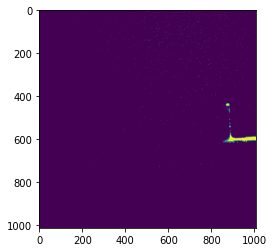

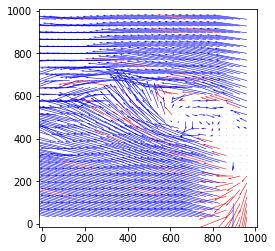

Image Pair 1
2image_00.tif 2image_01.tif


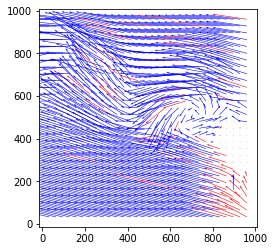

Image Pair 2
2image_10.tif 2image_11.tif


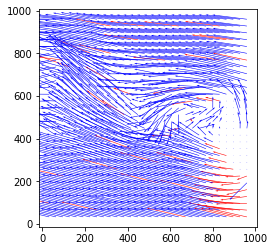

Image Pair 3
2image_20.tif 2image_21.tif


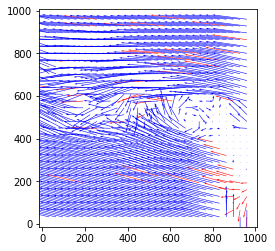

Image Pair 4
2image_30.tif 2image_31.tif


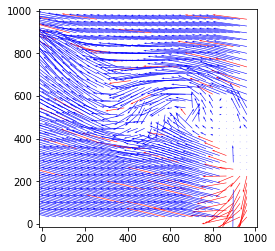

Image Pair 5
2image_40.tif 2image_41.tif


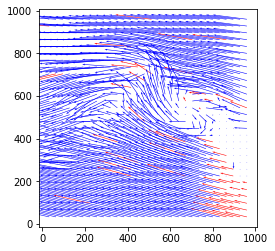

Image Pair 6
2image_50.tif 2image_51.tif


In [ ]:
test_static_masking()